In [15]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [16]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, RDKitMinimalLib, GLM

import PyPlot; const plt = PyPlot;
include("../saftvrmienn.jl");

In [17]:
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1);

In [18]:
chemical_family = "Alkanes"

if lowercase(chemical_family) == "linear alkanes"
    contains_only_c(name) = all(letter -> lowercase(letter) == 'c', name);
    processed_data_lin_alkanes = filter(row -> contains_only_c(row.isomeric_SMILES), pcp_source_params) 
    processed_data = sort(processed_data_lin_alkanes, :Mw)
else
    processed_data = filter(row -> lowercase(row.family) == lowercase(chemical_family), pcp_source_params) 
    processed_data = sort(processed_data, :Mw)
end

processed_data.isomeric_SMILES;

In [63]:
isomeric_smiles = processed_data[!,:isomeric_SMILES]

fingerprints = []

for i in isomeric_smiles
    fingerprint_spec_i = []

    mol = get_mol(i)
    
    # fp_str1 = get_rdkit_fp(mol, Dict{String,Any}("minPath"=> 1, "maxPath" => 50))
    # fp_str2 = get_morgan_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 256))
    # fp_str = fp_str1*fp_str2

    fp_str = get_rdkit_fp(mol)
    # fp_str = get_pattern_fp(mol)
    
    append!(fingerprint_spec_i, [parse(Float64, string(c)) for c in fp_str])

    desc = get_descriptors(mol)
    relevant_keys = ["CrippenClogP", "NumHeavyAtoms", "amw", "FractionCSP3"]

    relevant_desc = [desc[k] for k in relevant_keys]
    append!(fingerprint_spec_i, relevant_desc)
    append!(fingerprints, [fingerprint_spec_i])

end

In [64]:
for num = [0, 1]
    num_cols = length(fingerprints[1])
    zero_cols = trues(num_cols)
    for vec in fingerprints
        zero_cols .&= (vec .== num)
    end
    keep_cols = .!zero_cols # Create a Mask
    fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
end

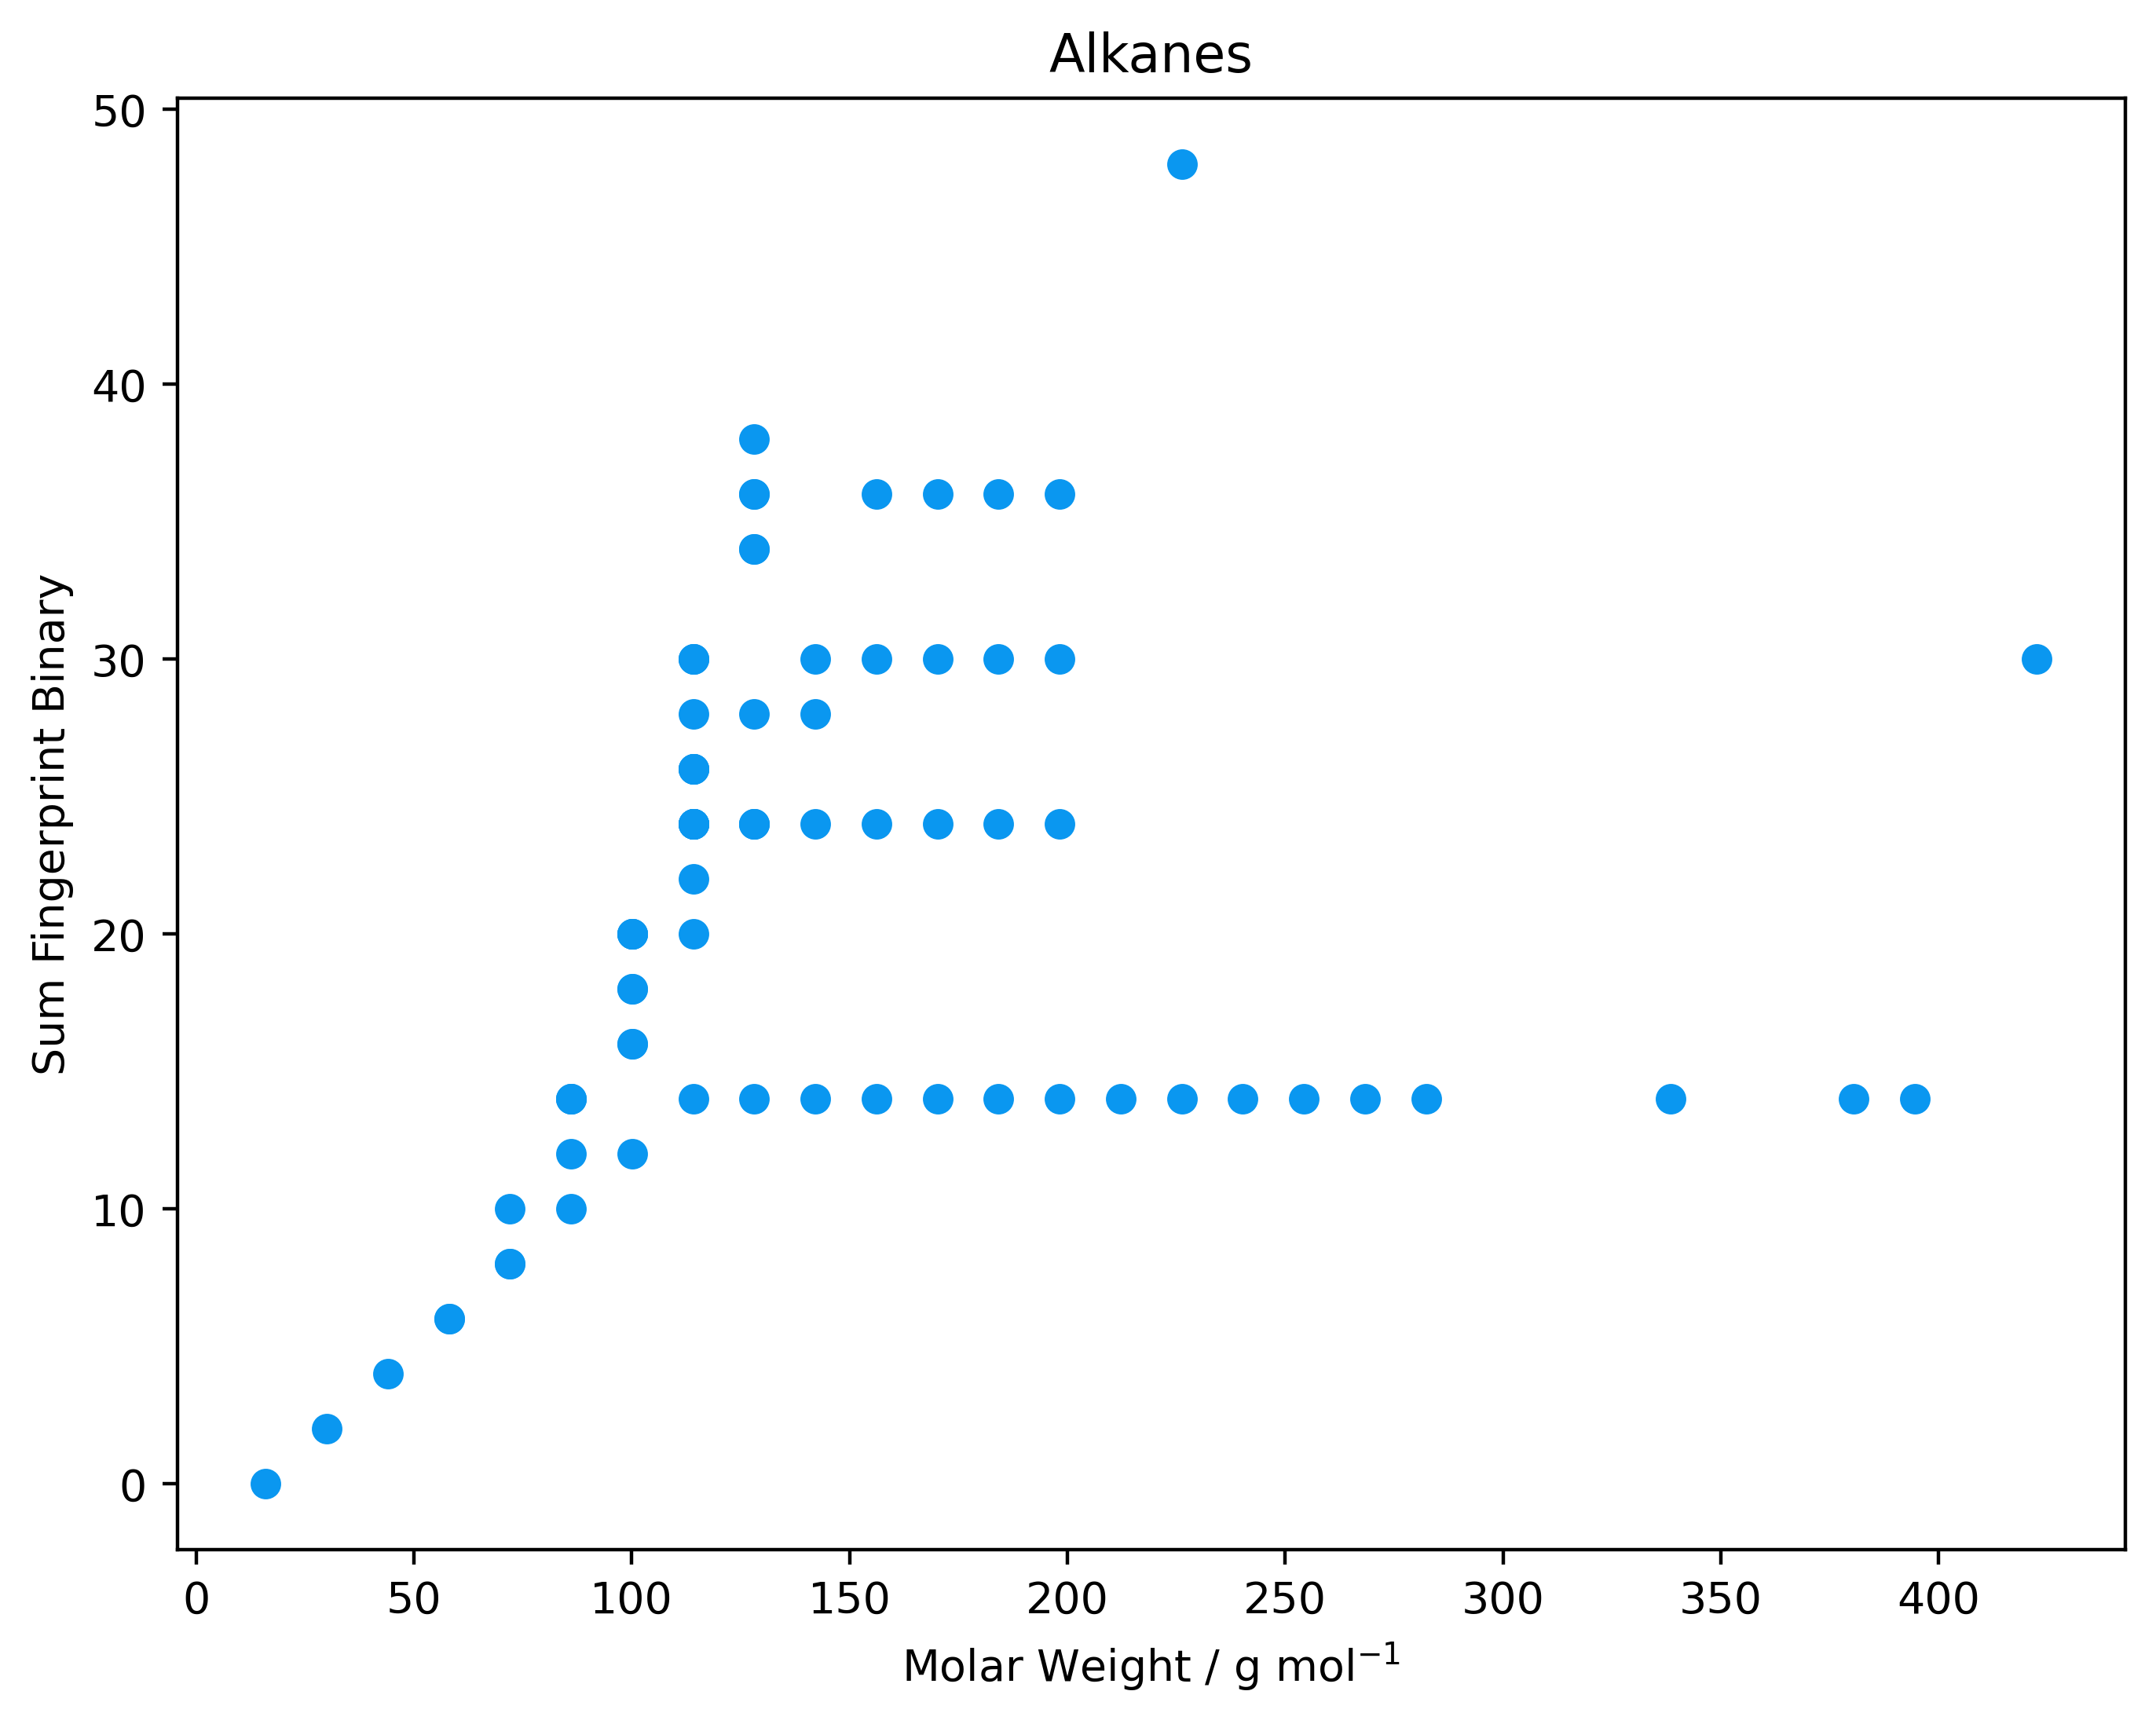

In [65]:
sum_elements = []

for i in fingerprints
    push!(sum_elements, sum(i[1:end-3]))
end

plt.figure(figsize=(8, 6), dpi=400)
plt.scatter(processed_data.Mw, sum_elements,color="#0a97f0")
plt.xlabel("Molar Weight / g mol\$^{-1}\$")
plt.ylabel("Sum Fingerprint Binary")
plt.title(chemical_family);
# plt.xlim([0, 500]);

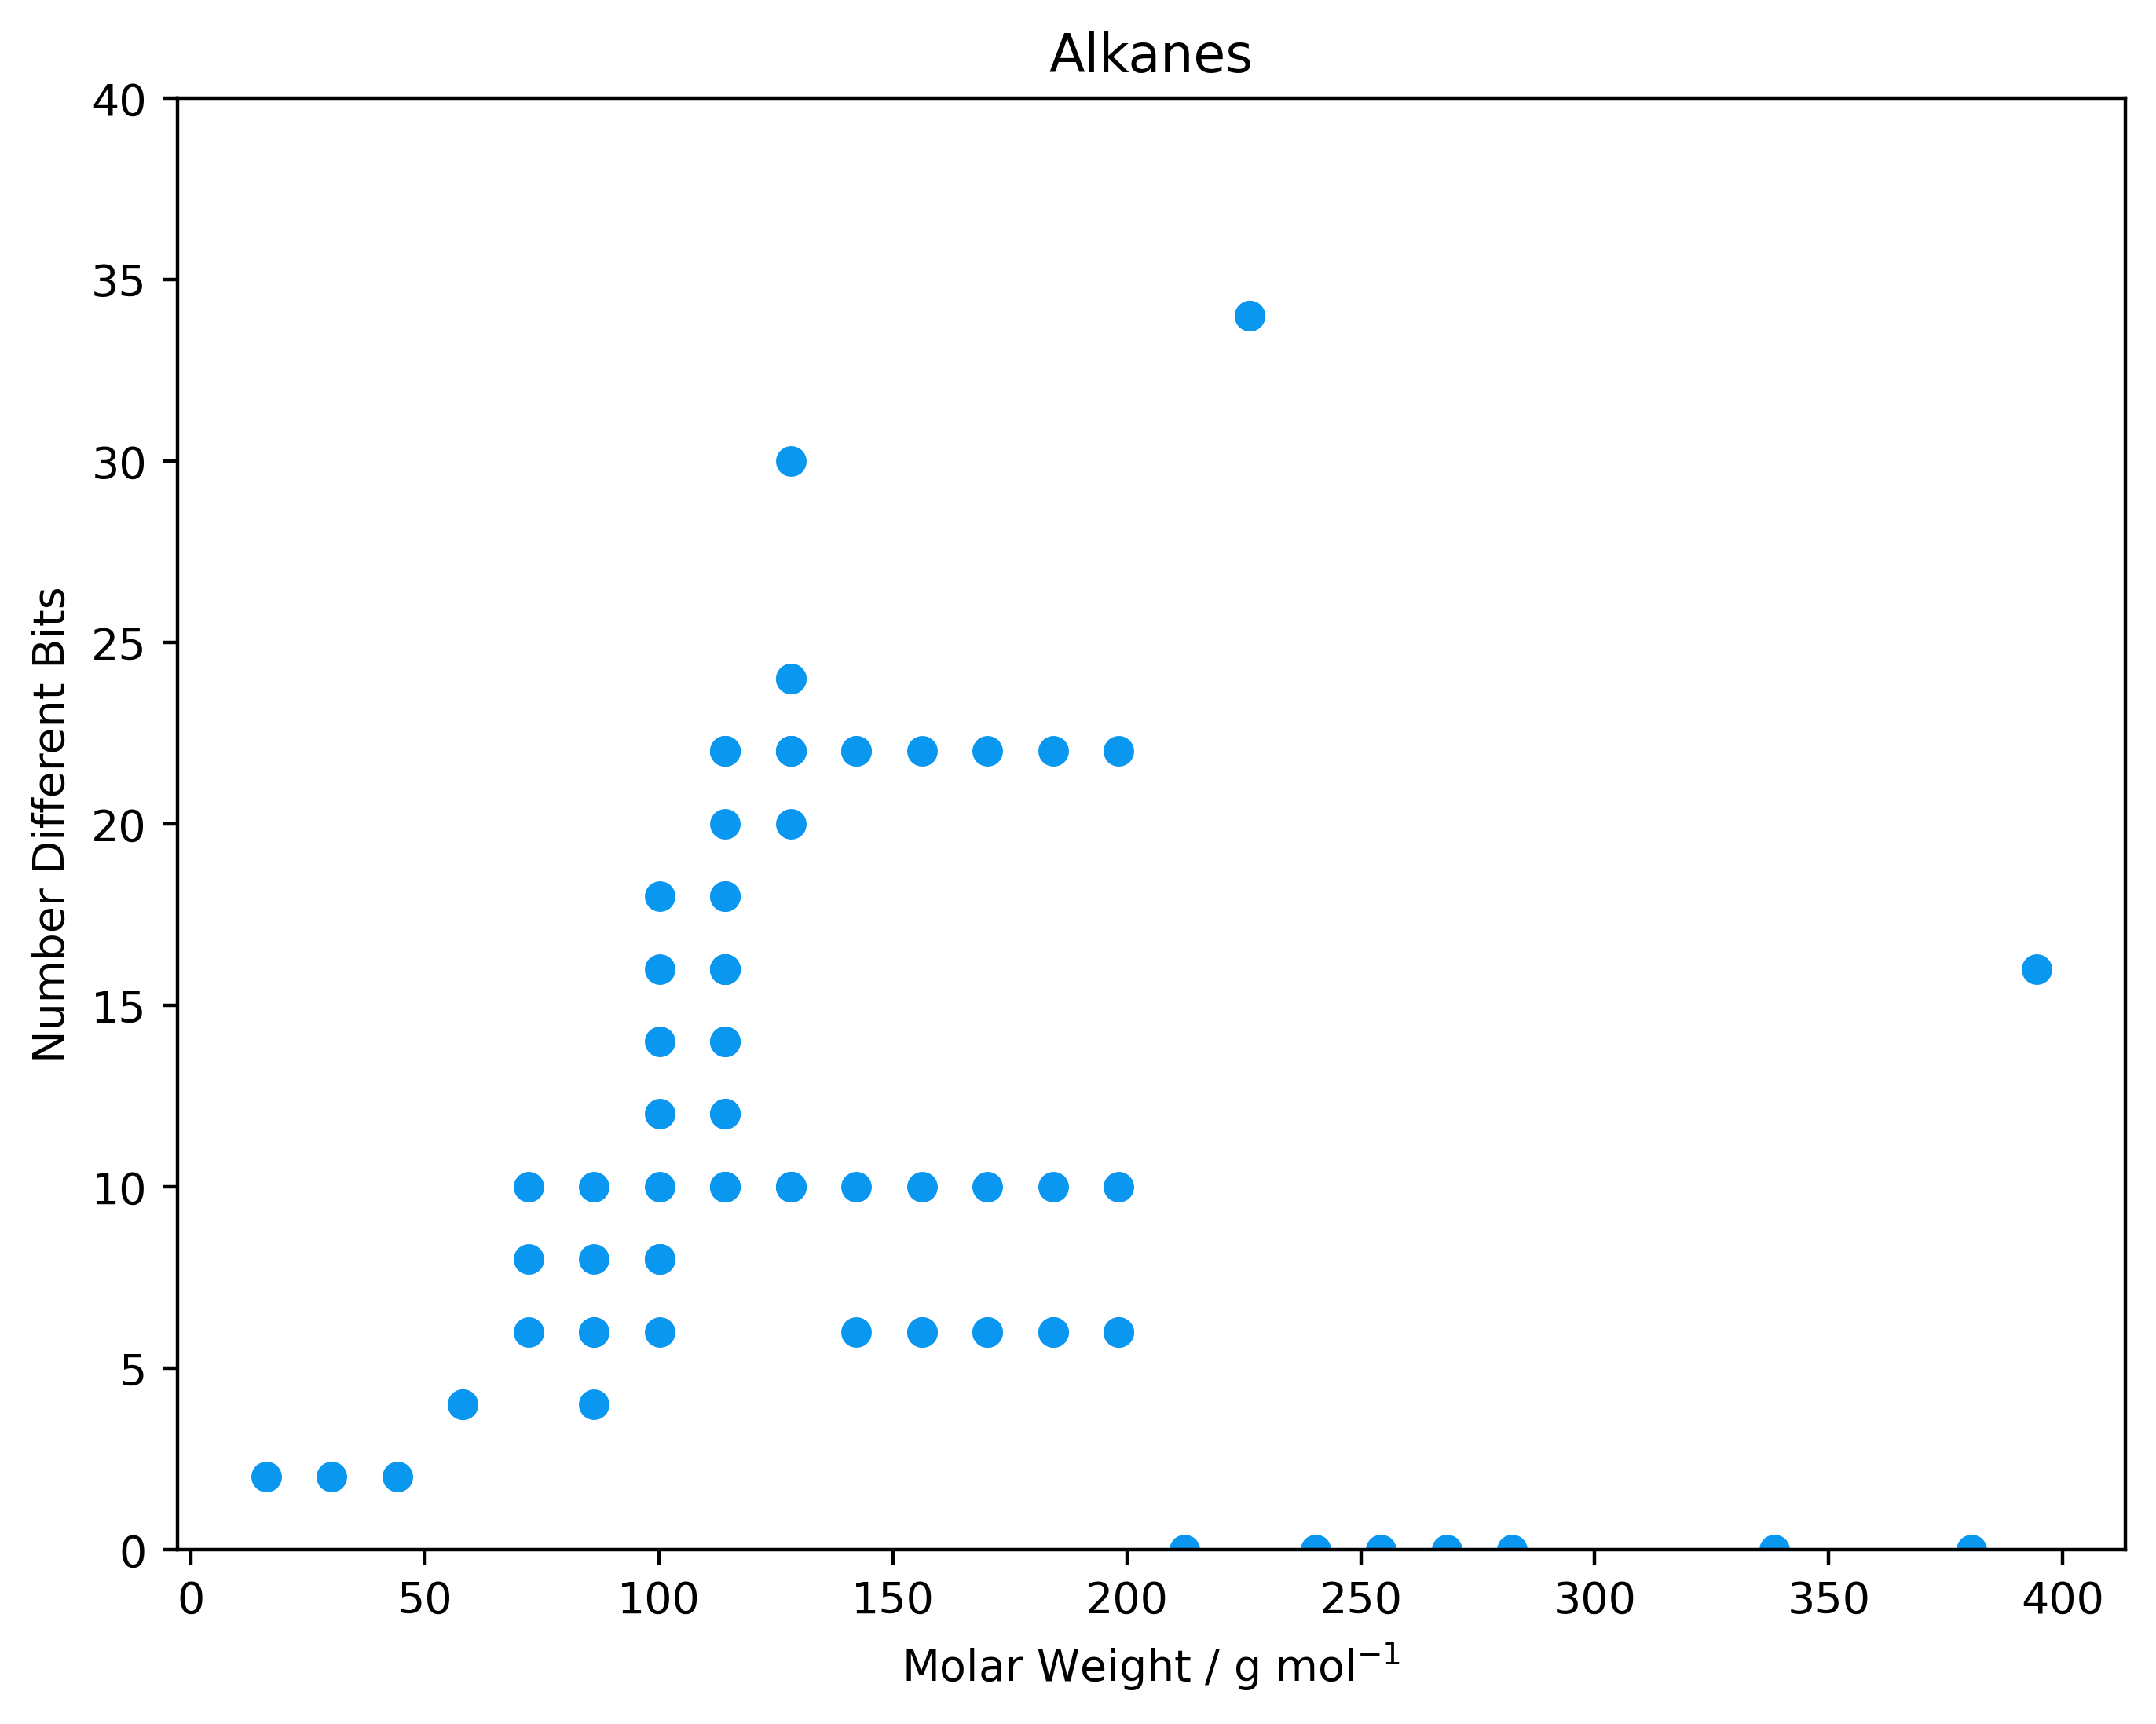

(0.0, 40.0)

In [68]:
x = []

for molecule = 1:length(fingerprints)-1
    num_in_common = 0

    # For a given chemical family, check how many bits differ between adjacent species (when ordered by increasing Mw)
    for i = 1:length(fingerprints[1])-3
        if fingerprints[molecule][i] ≠ fingerprints[molecule+1][i]
            num_in_common += 1
        end
    end
    push!(x, (molecule, num_in_common))
end

plt.figure(figsize=(8, 6), dpi=400)
plt.scatter(processed_data.Mw[1:end-1], last.(x),color="#0a97f0")
plt.ylabel("Number Different Bits")
plt.xlabel("Molar Weight / g mol\$^{-1}\$");
plt.title(chemical_family);
plt.ylim([0,40])

In [66]:
zero_difference_indices = findall(x->x==0, last.(x))
println(zero_difference_indices)
neighbouring_indices = [i + 1 for i in zero_difference_indices]
zero_difference_indices = vcat(zero_difference_indices, neighbouring_indices)

for i in zero_difference_indices
    println(i)
    println(processed_data[i,:species])
    println(fingerprints[i])
    # println(length(fingerprints[i]))
end

[70, 73, 74, 75, 76, 77, 78]
70
pentadecane
Any[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0975, 15.0, 212.42099]
73
heptadecane
Any[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.8777, 17.0, 240.47499]
74
octadecane
Any[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 

In [67]:
unique_values = unique(pcp_source_params[!, :family])
num_families = length(unique_values)
println(unique_values)

String31["Alkanes", "Inorganic compounds", "Other compounds", "Alkynes", "Nitriles", "Elements", "Alkenes", "Aldehydes", "Amines", "Silanes/siloxanes", "Alcohols", "Fluorides", "Cyclic compounds", "Acids", "Ethers", "Thiols", "Chlorides", "Ketones", "Polyfunctional compounds", "Sulfides/thiophenes", "Esters", "Aromatic hydrocarbons", "Halogenated compounds"]


In [74]:
function count_repeated_vectors(arr)
    vector_counts = Dict{Vector, Int}()

    for vector in arr
        if haskey(vector_counts, vector)
            vector_counts[vector] += 1
        else
            vector_counts[vector] = 1
        end
    end

    repeated_vectors = filter(kv -> kv[2] > 1, vector_counts)
    return repeated_vectors
end

minima = []
fingerprints_all_families = []

for i in unique_values
    println(i)
    filtered_data_chem_family = filter(row -> row.family == i, pcp_source_params) ;
    filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 
    isomeric_smiles_family = filtered_data_chem_family[!,:isomeric_SMILES]

    fingerprints_rdkit = []
    fingerprints_morgan = []
    fingerprints_atom_pair = []
    fingerprints_pattern = []
    fingerprints_total = []


    for i in isomeric_smiles_family

        fingerprint_spec_i_rdkit = []
        fingerprint_spec_i_morgan = []
        fingerprint_spec_i_atom_pair = []
        fingerprint_spec_i_pattern = []
        fingerprint_spec_i_total = []

        mol = get_mol(i)
        desc = get_descriptors(mol)
        relevant_keys = ["CrippenClogP", "amw", "FractionCSP3"]
        relevant_desc = [desc[k] for k in relevant_keys]

        fp_str_rdkit = get_rdkit_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 1024))
        # fp_str_morgan = get_morgan_fp(mol, Dict{String,Any}("minPath"=> 1, "maxPath" => 50))
        fp_str_morgan = get_morgan_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 256))
        fp_str_atom_pair = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 1024))
        fp_str_pattern = get_pattern_fp(mol, Dict{String,Any}("radius"=> 7, "nbits" => 1024))

        fp_str_rdkit_total = fp_str_rdkit  * fp_str_atom_pair * fp_str_pattern
        
        append!(fingerprint_spec_i_rdkit, [parse(Float64, string(c)) for c in fp_str_rdkit])
        append!(fingerprint_spec_i_morgan, [parse(Float64, string(c)) for c in fp_str_morgan])
        append!(fingerprint_spec_i_atom_pair, [parse(Float64, string(c)) for c in fp_str_atom_pair])
        append!(fingerprint_spec_i_pattern, [parse(Float64, string(c)) for c in fp_str_pattern])
        append!(fingerprint_spec_i_total, [parse(Float64, string(c)) for c in fp_str_rdkit_total])

        append!(fingerprint_spec_i_rdkit, relevant_desc)
        append!(fingerprint_spec_i_morgan, relevant_desc)
        append!(fingerprint_spec_i_atom_pair, relevant_desc)
        append!(fingerprint_spec_i_pattern, relevant_desc)
        append!(fingerprint_spec_i_total, relevant_desc)

        append!(fingerprints_rdkit, [fingerprint_spec_i_rdkit])
        append!(fingerprints_morgan, [fingerprint_spec_i_morgan])
        append!(fingerprints_atom_pair, [fingerprint_spec_i_atom_pair])
        append!(fingerprints_pattern, [fingerprint_spec_i_pattern])
        append!(fingerprints_total, [fingerprint_spec_i_total])

    end

    all_fingerprints = [fingerprints_rdkit, fingerprints_morgan, fingerprints_atom_pair, fingerprints_pattern, fingerprints_total]

    for i in 1:length(all_fingerprints)

        fingerprints = all_fingerprints[i]

        for num = [0, 1]
            num_cols = length(fingerprints[1])
            zero_cols = trues(num_cols)
            for vec in fingerprints
                zero_cols .&= (vec .== num)
            end
            keep_cols = .!zero_cols # Create a Mask
            all_fingerprints[i] = [vec[keep_cols] for vec in fingerprints] # Apply Mask
        end
    end

    repeats_all_fp = []
    for i in all_fingerprints
        repeated_vectors = count_repeated_vectors(i)
        repeated = []

        if isempty(repeated_vectors)
        else
            for (vector, count) in repeated_vectors
                push!(repeated, count)
            end
            println(repeated)
            push!(repeats_all_fp,sum(repeated))
        end
    end
    
    println(repeats_all_fp)

    push!(fingerprints_all_families,all_fingerprints)

end

Alkanes
Any[2]
Any[2]
Inorganic compounds
Any[]
Other compounds
Any[2, 3, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Any[2, 2, 2, 2, 2, 2, 2]
Any[2, 2, 2, 2, 2, 2, 2, 2]
Any[2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2]
Any[2, 2, 2, 2, 2, 2, 2]
Any[45, 14, 16, 63, 14]
Alkynes
Any[2]
Any[2]
Nitriles
Any[]
Elements
Any[]
Alkenes
Any[2, 2, 2, 2, 2, 2, 2]
Any[2, 2, 2, 2, 2, 2, 2]
Any[2, 2, 2, 2, 2, 2, 2]
Any[2, 2, 6, 5, 3]
Any[2, 2, 2, 2, 2, 2, 2]
Any[14, 14, 14, 18, 14]
Aldehydes
Any[]
Amines
Any[]
Silanes/siloxanes
Any[]
Alcohols
Any[2]
Any[2]
Any[2]
Any[2]
Any[2]
Any[2, 2, 2, 2, 2]
Fluorides
Any[]
Cyclic compounds
Any[2, 2, 2, 2, 2, 2]
Any[2, 2, 2, 2, 2, 2]
Any[2, 2, 2, 2, 2, 2]
Any[2, 2, 2, 2, 2, 2]
Any[2, 2, 2, 2, 2, 2]
Any[12, 12, 12, 12, 12]
Acids
Any[]
Ethers
Any[3, 2]
Any[5]
Thiols
Any[]
Chlorides
Any[2, 2]
Any[2, 2]
Any[2, 2]
Any[2, 2]
Any[2, 2]
Any[4, 4, 4, 4, 4]
Ketones
Any[2, 2]
Any[4]
Polyfunctional compounds
Any[]
Sulfides/

In [51]:
fingerprints_all_families[1]

5-element Vector{Vector{Any}}:
 [Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6361, 16.043], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0262, 30.07], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4163, 44.09699], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8064, 58.12399], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.66229, 58.12399], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0524, 72.151], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1965, 72.151], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0524, 72.151], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [57]:
repeats_all_fp = []
# for i in all_fingerprints
    # print(i)
    repeated_vectors = count_repeated_vectors(fingerprints_all_families[3][1])
    println(repeated_vectors)
    repeated = []

    for (vector, count) in repeated_vectors
        push!(repeated,count)
        println(count)
    end
    # push!(repeats_all_fp,sum(repeated))
# end

Dict{Vector, Int64}(Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

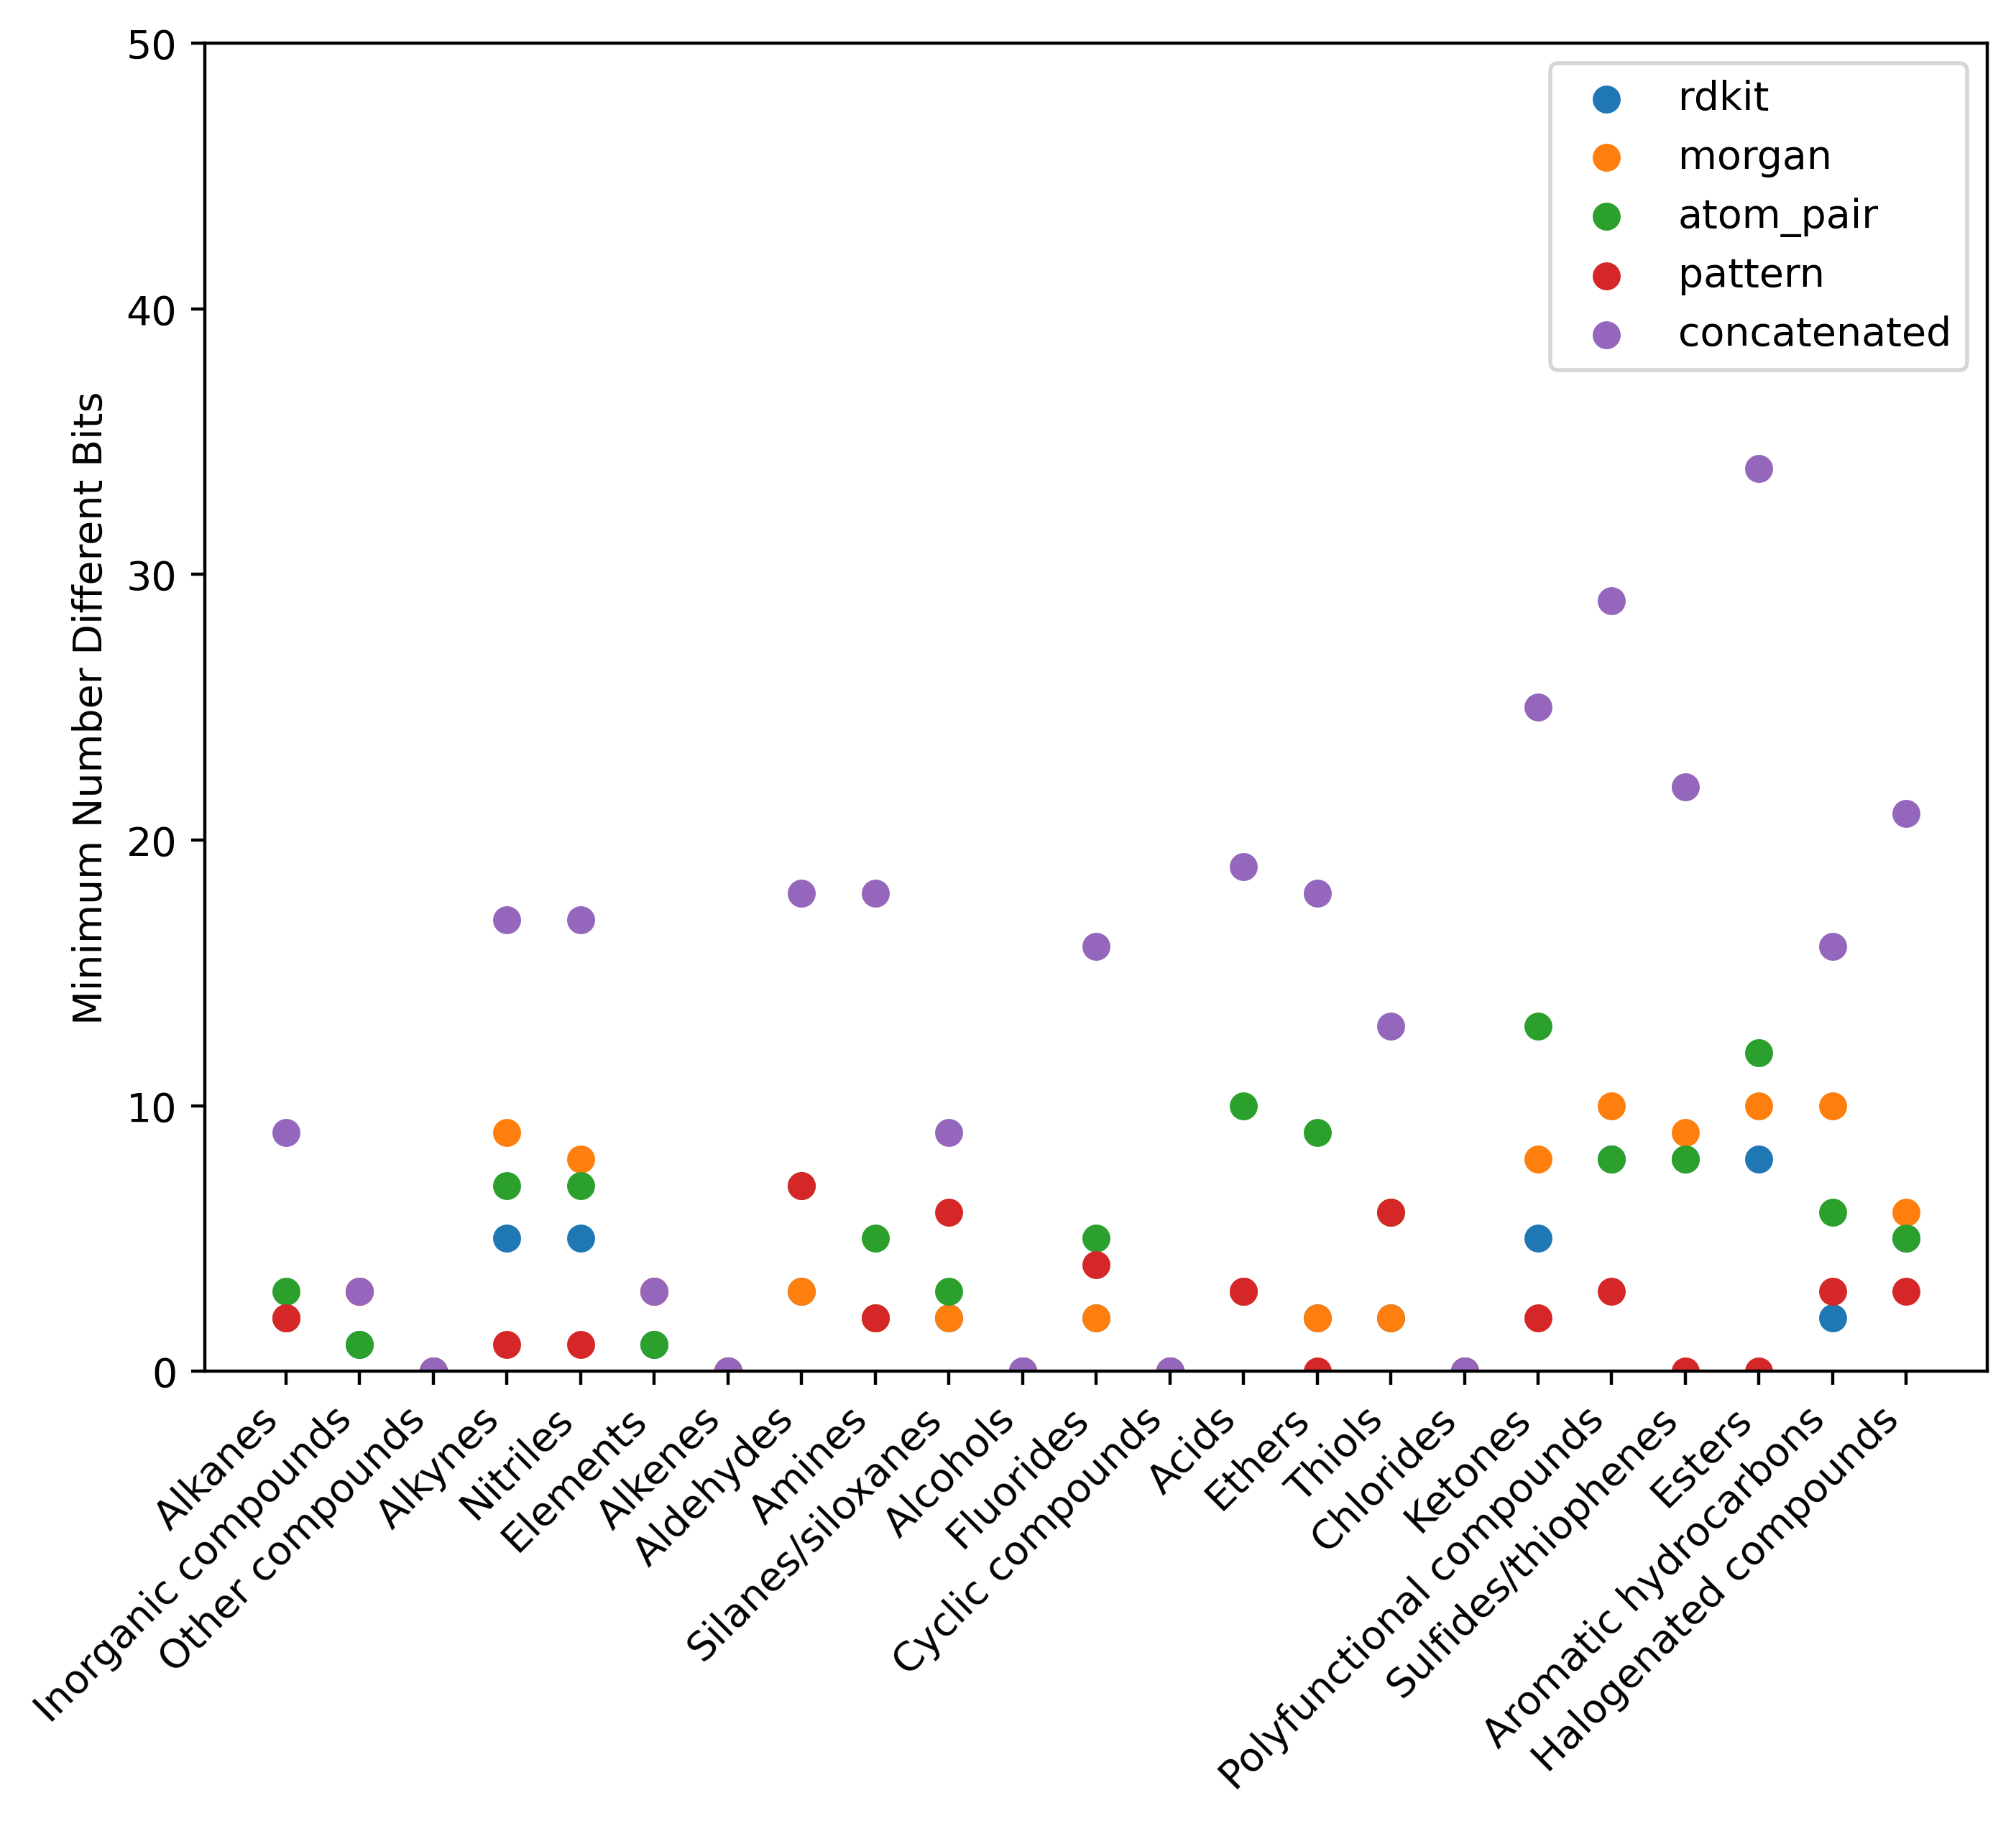

(0.0, 50.0)

In [26]:
rdkit_minima = [minima[i][1] for i = 1:length(minima)]
morgan_minima = [minima[i][2] for i = 1:length(minima)]
atom_pair_minima = [minima[i][3] for i = 1:length(minima)]
pattern_minima = [minima[i][4] for i = 1:length(minima)]
total_minima = [minima[i][5] for i = 1:length(minima)]

plt.figure(figsize=(8, 6), dpi=400)
plt.scatter(unique_values, rdkit_minima)
plt.scatter(unique_values, morgan_minima)
plt.scatter(unique_values, atom_pair_minima)
plt.scatter(unique_values, pattern_minima)
plt.scatter(unique_values, total_minima)

plt.ylabel("Minimum Number Different Bits")
plt.legend(["rdkit","morgan","atom_pair","pattern","concatenated"])
plt.xticks(rotation=45,ha="right");
plt.ylim([0, 50])

# Add length of fingerprint to plot - is it beneficial to have 10x the number of different bits if the length
# increases proportionately?
# Adjust minimum to look over the entire chemical family rather than for just adjacent species
# Check repetitions - if they are all cis/trans stereoisomers, then that is acceptable as SAFT can't account for
# this difference


In [32]:
println(length(fingerprints_all_families[3][2]))

622


In [41]:
# Function to check if an array contains two identical vectors
k = 0
array = fingerprints_all_families[7][2]
for i in 1:length(array)
    for j in i+1:length(array)
        if array[i] == array[j]
            k =+ 1
        end
    end
end

println(k)



1


Repeated Vectors:
Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [ ]:
minima = []
fingerprints_all_families = []

for i in unique_values
    println(i)
    filtered_data_chem_family = filter(row -> row.family == i, pcp_source_params) ;
    filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 
    isomeric_smiles_family = filtered_data_chem_family[!,:isomeric_SMILES]

    fingerprints_rdkit = []
    fingerprints_morgan = []
    fingerprints_atom_pair = []
    fingerprints_pattern = []
    fingerprints_total = []


    for i in isomeric_smiles_family

        fingerprint_spec_i_rdkit = []
        fingerprint_spec_i_morgan = []
        fingerprint_spec_i_atom_pair = []
        fingerprint_spec_i_pattern = []
        fingerprint_spec_i_total = []

        mol = get_mol(i)
        desc = get_descriptors(mol)
        relevant_keys = ["CrippenClogP", "amw", "FractionCSP3"]
        relevant_desc = [desc[k] for k in relevant_keys]

        fp_str_rdkit = get_rdkit_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 1024))
        # fp_str_morgan = get_morgan_fp(mol, Dict{String,Any}("minPath"=> 1, "maxPath" => 50))
        fp_str_morgan = get_morgan_fp(mol, Dict{String,Any}("radius"=> 4, "nbits" => 256))
        fp_str_atom_pair = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 1024))
        fp_str_pattern = get_pattern_fp(mol, Dict{String,Any}("radius"=> 7, "nbits" => 1024))

        fp_str_rdkit_total = fp_str_rdkit  * fp_str_atom_pair * fp_str_pattern
        
        append!(fingerprint_spec_i_rdkit, [parse(Float64, string(c)) for c in fp_str_rdkit])
        append!(fingerprint_spec_i_morgan, [parse(Float64, string(c)) for c in fp_str_morgan])
        append!(fingerprint_spec_i_atom_pair, [parse(Float64, string(c)) for c in fp_str_atom_pair])
        append!(fingerprint_spec_i_pattern, [parse(Float64, string(c)) for c in fp_str_pattern])
        append!(fingerprint_spec_i_total, [parse(Float64, string(c)) for c in fp_str_rdkit_total])

        append!(fingerprint_spec_i_rdkit, relevant_desc)
        append!(fingerprint_spec_i_morgan, relevant_desc)
        append!(fingerprint_spec_i_atom_pair, relevant_desc)
        append!(fingerprint_spec_i_pattern, relevant_desc)
        append!(fingerprint_spec_i_total, relevant_desc)

        append!(fingerprints_rdkit, [fingerprint_spec_i_rdkit])
        append!(fingerprints_morgan, [fingerprint_spec_i_morgan])
        append!(fingerprints_atom_pair, [fingerprint_spec_i_atom_pair])
        append!(fingerprints_pattern, [fingerprint_spec_i_pattern])
        append!(fingerprints_total, [fingerprint_spec_i_total])

    end

    all_fingerprints = [fingerprints_rdkit, fingerprints_morgan, fingerprints_atom_pair, fingerprints_pattern, fingerprints_total]

    for i in 1:length(all_fingerprints)

        fingerprints = all_fingerprints[i]

        for num = [0, 1]
            num_cols = length(fingerprints[1])
            zero_cols = trues(num_cols)
            for vec in fingerprints
                zero_cols .&= (vec .== num)
            end
            keep_cols = .!zero_cols # Create a Mask
            all_fingerprints[i] = [vec[keep_cols] for vec in fingerprints] # Apply Mask
        end
    end

    minima_per_fingerprint = []

    for i in 1:length(all_fingerprints)
        fingerprints = all_fingerprints[i]

        num_diff_for_adjacent_spec_in_fam = []

        for molecule = 1:length(fingerprints)-1
            num_different = 0
            # For a given chemical family, check how many bits differ between adjacent species (when ordered by increasing Mw)
            for i = 1:length(fingerprints[1])
                if fingerprints[molecule][i] ≠ fingerprints[molecule+1][i]
                    num_different += 1
                end
            end
            push!(num_diff_for_adjacent_spec_in_fam, num_different)
        end
        println(count(i->(i == 0), num_diff_for_adjacent_spec_in_fam)) 
        push!(minima_per_fingerprint, minimum(num_diff_for_adjacent_spec_in_fam))
    end

    push!(fingerprints_all_families,all_fingerprints)
    push!(minima, minima_per_fingerprint)
end